# Titanic

### 简单介绍
kaggle入门题目，通过titanic号乘客的信息，预测是否生还的问题，典型的二分类问题。   
   
通过对数据的简单分析(数值型和类别型特征),可视化，通过Pipeline预处理数据， 使用LR， RF，lightgbm以及tensorflow搭建神经网络对结果进行预测输出。

注：所使用数据集从kaggle下载，完成结果后至kaggle提交， 查看分数排名。
建议初学者一定完成预测并进行结果提交。

## 常用包的导入

In [1]:
# 基本包的导入
import numpy as np
import os

# 画图相关
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
# measure
from sklearn.metrics import accuracy_score

# 忽略警告
import warnings

DATASET_DIR = "./dataset"

In [2]:
# 上述函数，其输入是包含1个多个枚举类别的2D数组，需要reshape成为这种数组.对类别数据进行one-hot编码
# from sklearn.preprocessing import CategoricalEncoder  #后面会添加这个方法

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array

from scipy import sparse

# 后面再去理解
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out


In [3]:
# 另一个转换器：用于选择子集
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

上述两个类通过继承BaseEstimator， TransformerMixin， 可以实现sklearn中常用的fit，fit_transform等方法，其中前者用于对类别数据进行one-hot编码，后者根据特征进行数据选择。

## 数据的导入

In [4]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
sample_df = pd.read_csv('./dataset/gender_submission.csv')
combine_df = [train_df, train_df]

上述方法导入数据，其中train_df用于训练和验证，test_df是测试数据，根据测试数据进行预测，保存结果并提交。

### 初步了解数据

In [5]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


查看前10条数据(默认5条)，可以了解到的信息有：
1. Survived取值为0，1，表示是否存活，即需要预测的数据。Pclass取值为3，2，1， 等等
2. 注意区分类别特征和连续数值特征，后续进行处理。
3. 名字和Ticket看起来对结果无规律，可以删除。

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


上述方法对数值特征进行简单计算统计，包括技术，平均数，标准差，最值，25%, 50%, 75%的分布情况。
此图有很多重要的信息：
1. 有接近38%的人存活。(平均值的计算)， 由0，1表示。
2. silsp表示兄弟姐妹，parch表示配偶，一起表示随亲友出行的个数。75%的人都是0， 说明都是单人出行。
3. 将近30%的乘客有兄弟姐妹和/或配偶。
4. 票价差别很大，几乎没有乘客(<1%)支付高达512美元。
5. 几乎没有乘客是65-80岁的。

In [7]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",male,1601,C23 C25 C27,S
freq,1,577,7,4,644


与前一方法不同，该方法表示对非数值特征进行简单统计，包括技术，unique，top(出现最多的类别)， freq(出现最多的次数)。  
可以看到577人为男性，Embarked中S出现最多，为644次。

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [9]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


上述方法查看每个特征是否为空的情况，几个信息如下：
1. 共计891个实例，12列。
2. Name, Ticket,Cabin，Embatked为object对象，即类别特征。
3. 其中float64特征数为2， int64特征数为5， object特征数为5.
4. Age年龄特征有部分空值，可以考虑补全。Cabin有大量空值，后续可以考虑删除。

## 简单分析和可视化

### 单变量可视化
下面对部分特征进行可视化，对数据特征有个大概了解。  
官方文档：http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html  
数据可视化教程：https://www.kaggle.com/residentmario/univariate-plotting-with-pandas  

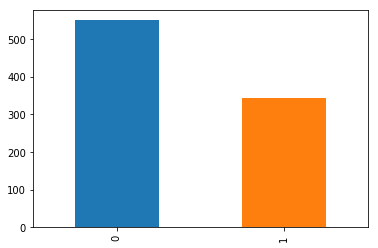

In [10]:
train_df['Survived'].value_counts().plot.bar()  # 存活人数可视化

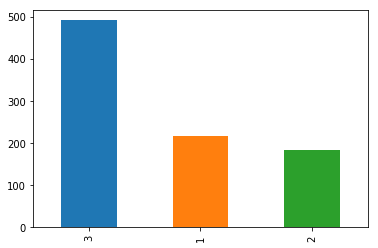

In [11]:
train_df['Pclass'].value_counts().plot.bar() # Pclass的分布情况

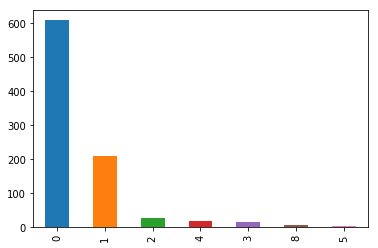

In [12]:
train_df['SibSp'].value_counts().plot.bar()  

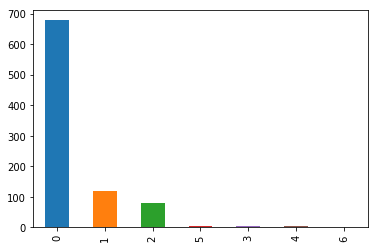

In [13]:
train_df['Parch'].value_counts().plot.bar()  

### 二元变量可视化

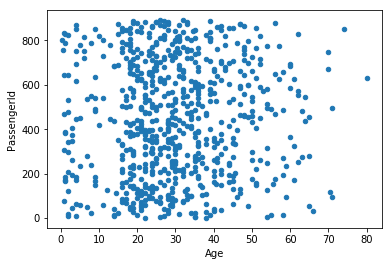

In [14]:
train_df[train_df['Age'] <= 100].plot.scatter(x='Age', y="PassengerId")  #年龄的分布情况

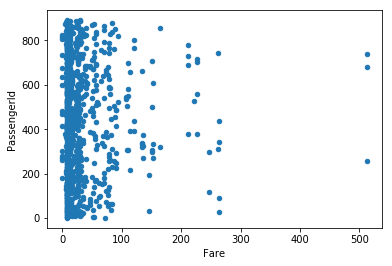

In [15]:
train_df[train_df['Fare'] <= 800].plot.scatter(x='Fare', y="PassengerId")  # 票价的分布

## 数据分析

### 下列分析不同特征与存活率的区别

In [16]:
train_df[["Pclass", "Survived"]].groupby(['Pclass'],as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [17]:
train_df.groupby(['Pclass'], as_index=False)[['Survived']].mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


上述两种分组聚类查看的结果一样，方法不同。后者在我看来更容易理解。

可以看到船票类型为1的存活率最高，说明有一定的相关性。

In [18]:
# 下列分析不同特征与存活率的区别
train_df[["Sex", "Survived"]].groupby(['Sex'],as_index=False).mean().sort_values(by="Survived", ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [19]:
# 下列分析不同特征与存活率的区别
train_df[["SibSp", "Survived"]].groupby(['SibSp'],as_index=False).mean().sort_values(by="Survived", ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [20]:
# 下列分析不同特征与存活率的区别
train_df[["Parch", "Survived"]].groupby(['Parch'],as_index=False).mean().sort_values(by="Survived", ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


以上是针对不同特征的存活率对比，下面通过可视化来观察。

### sns 多个变量分组查看可视化

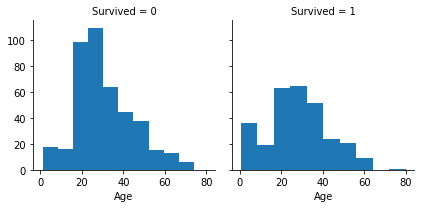

In [21]:
g = sns.FacetGrid(train_df, col="Survived") 
# g.map(plt.hist, "Age", bins=20)
g.map(plt.hist, 'Age')

上图是存活与否与年级的关系。有几个点需要注意：
1. 0-4岁的孩子存活率较高
2. 80岁的乘客存活
3. 15-25岁之间有大量的程序死亡
4. 乘客年龄主要集中在15-35岁。

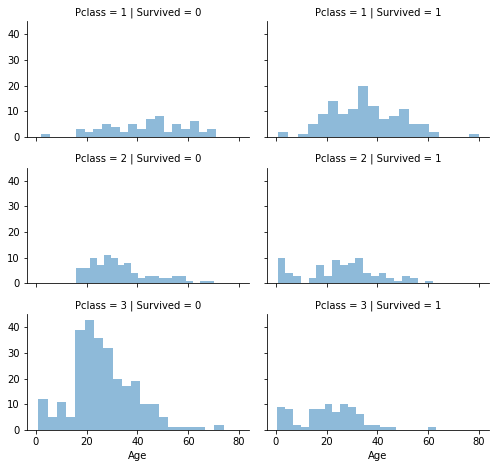

In [22]:
# grid = sns.FacetGrid(train_df, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, "Age", alpha=0.5, bins=20)

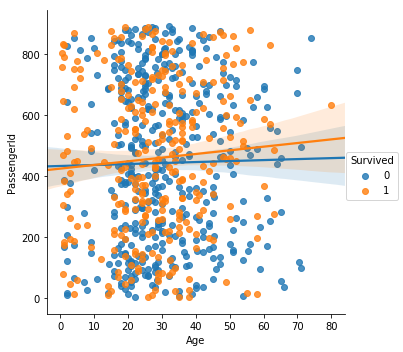

In [23]:
sns.lmplot(x="Age", y="PassengerId", hue='Survived', data=train_df)

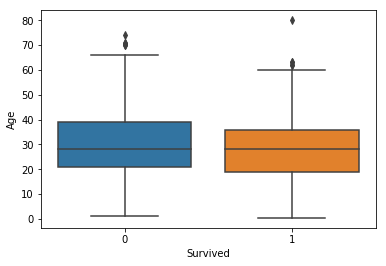

In [24]:
sns.boxplot(x="Survived", y="Age", data=train_df)  #能显示出一组数据的最大值、最小值、中位数、及上下四分位数。

In [25]:

# 数据间的相互关系
corr_matrix = train_df.corr()

In [26]:
corr_matrix["Survived"].sort_values() #数据建的相互相关， 1， -1 最有用

Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
PassengerId   -0.005007
Parch          0.081629
Fare           0.257307
Survived       1.000000
Name: Survived, dtype: float64

如上信息可以知道大概的数据分布， 数值型和类别型信息，以及特征为空的情况。

## 数据预处理

### 缺失值的处理(删除或者补全)

In [27]:
# 有上述分析可知，Cabin缺失较多，可以删除
train_df = train_df.drop(['Cabin'], axis = 1)
test_df = test_df.drop(['Cabin'], axis = 1)

In [28]:
# Age项有部分缺失，使用Imputer，中位数补全
age_median = train_df.median()['Age']
train_df['Age'] = train_df['Age'].fillna(age_median)
test_df['Age'] = test_df['Age'].fillna(age_median)

In [29]:
# 其中 Embarked也有缺失，类别数据可用最多出现项补全。
Embarked_freq = 'S'
train_df["Embarked"] = train_df["Embarked"].fillna("S")
test_df["Embarked"] = test_df["Embarked"].fillna("S")

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
dtypes: float64(2), int64(5), object(4)
memory usage: 76.6+ KB


In [31]:
test_df.info()  #Fare有缺失，用中位值补全
Embarked_median = train_df.median()['Fare']
train_df['Fare'] = train_df['Fare'].fillna(Embarked_median)
test_df['Fare'] = test_df['Fare'].fillna(Embarked_median)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 32.7+ KB


### 处理类别数据

关于类别数据，对其进行one-hot编码处理，可用上述CategoricalEncoder编码，也可以使用pandas.get_dummies处理.

In [32]:
Sex = pd.get_dummies(train_df['Sex'], prefix="Sex")
train_df = pd.concat([train_df, Sex], axis = 1)  # 连接两个pd

Sex = pd.get_dummies(test_df['Sex'], prefix="Sex")
test_df = pd.concat([test_df, Sex], axis = 1)  # 连接两个pd

In [33]:
Embarked = pd.get_dummies(train_df['Embarked'], prefix="Embarked")
train_df = pd.concat([train_df, Embarked], axis = 1)  # 连接两个pd

Embarked = pd.get_dummies(test_df['Embarked'], prefix="Embarked")
test_df = pd.concat([test_df, Embarked], axis = 1)  # 连接两个pd

In [34]:
train_df.head() 

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,0,1,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,0,1,0,0,1


In [35]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,0,1,0,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,1,0,0,0,1


可以看到基本的特征已经处理完毕，删除不必要的特征，使用模型进行训练。

## 模型训练

In [36]:
no_use_features = ["PassengerId", 'Pclass', 'Sex', 'Name', 'Ticket', 'Embarked', 'Survived']

In [37]:
X_train = train_df[[i for i in train_df.columns if i not in no_use_features]]
y_train = train_df['Survived']

X_test = test_df[[i for i in test_df.columns if i not in no_use_features]]


分层抽样生成训练集和验证集，用于训练和选择好最佳参数

In [38]:
import sklearn
X_train, X_verify, y_train, y_verify = sklearn.model_selection.train_test_split(X_train, y_train, 
                                                                               stratify=y_train,
                                                                               test_size=0.1)

In [39]:
X_train.shape, X_verify.shape

((801, 9), (90, 9))

先使用最简单的分类模型，逻辑回归简单验证目前的方案基本可行，使用交叉熵最为测量标准，识别率用于显示精确度。


In [40]:
def measure(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_verify)
    score = sklearn.metrics.accuracy_score(y_verify, y_pred)
    loss = sklearn.metrics.log_loss(y_verify, y_pred)
    print('loss:', loss, 'score:', score)

In [41]:
# 逻辑回归
log_reg = sklearn.linear_model.LogisticRegression()
measure(log_reg)

loss: 6.907790816645702 score: 0.8


In [42]:
 # svm
svm_clf = sklearn.svm.SVC(probability=True)
measure(svm_clf)  # 目前识别率有提高

loss: 10.745521482461355 score: 0.6888888888888889


In [43]:
# 下面采用一些集成方法， 比如RF
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
measure(rf_clf)

loss: 8.442891967387853 score: 0.7555555555555555


下面使用cv对rf参数进行搜索调节

In [44]:
from sklearn.grid_search import RandomizedSearchCV
parmas_list = {
    'n_estimators':range(110, 130),
    'max_features':range(3, 8),
    'max_depth':range(3, 6),
}
grid = RandomizedSearchCV(rf_clf, parmas_list,cv=3, n_jobs=-1)
grid.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': range(110, 130), 'max_features': range(3, 8), 'max_depth': range(3, 6)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring=None, verbose=0)

In [45]:
grid.best_params_

{'max_depth': 5, 'max_features': 4, 'n_estimators': 116}

In [46]:
grid.best_score_

0.8052434456928839

In [47]:
# 用最优的模型进行预测, 此外还可以进行网格搜索调参
measure(grid.best_estimator_)  # 可以看到结果明显提高

loss: 4.988961021401439 score: 0.8555555555555555


此外,还可以将上述方法进行组合投票，得到更优的结果

In [48]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[("log_reg", log_reg), ("svm", svm_clf), ("rf_clf", grid.best_estimator_)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)
measure(voting_clf)

loss: 5.372734087983004 score: 0.8444444444444444


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## 预测结果并保存到文件，提交kaggle评分

In [49]:
X_train.shape, X_test.shape

((801, 9), (418, 9))

In [50]:
# 记住，上述对训练集的处理，也要同时处理测试集， 生成测试数据.
y_test = voting_clf.predict(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [51]:
sample_df['Survived'] = y_test

In [52]:
sample_df.to_csv('./result.csv', index=False)

到此为止，一个完整的机器学习项目完成，其中包括数据导入，简单可视化，数据分析，预处理，模型选择，训练，调参，输出到文件等内容。 
此外， 在特征处理和模型调参方面还可以做进一步深入。

## 模型融合：stacking

In [53]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [54]:
n_folds = 10

In [67]:
no_use_features = ["PassengerId", 'Pclass', 'Sex', 'Name', 'Ticket', 'Embarked', 'Survived']
X_train = train_df[[i for i in train_df.columns if i not in no_use_features]]
y_train = train_df['Survived']

X_test = test_df[[i for i in test_df.columns if i not in no_use_features]]
m, n = X_train.shape

In [60]:
skf = list(StratifiedKFold(y_train, n_folds))

In [77]:
clfs = [RandomForestClassifier(n_estimators=100, n_jobs=-1), 
       ExtraTreesClassifier(n_estimators=100, n_jobs=-1), 
       GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=50), 
       AdaBoostClassifier(n_estimators=100)]

In [78]:
dataset_blend_train = np.zeros( (m, len(clfs) ))
dataset_blend_test = np.zeros( (X_test.shape[0], len(clfs)) )

In [79]:
for j, clf in enumerate(clfs):
#     print(j, clf)
    dataset_blend_test_j = np.zeros((X_test.shape[0], len(skf)))
    for i, (train, verify) in enumerate(skf):
        X_t = X_train.values[train]
        Y_t = y_train.values[train]
        X_v = X_train.values[verify]
        Y_v = y_train.values[verify]
        clf.fit(X_t, Y_t)
        y_pred = clf.predict(X_v)
        dataset_blend_train[verify, j] = y_pred
        dataset_blend_test_j[:, i] = clf.predict(X_test)
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)

In [89]:
clf = LogisticRegression()
clf.fit(dataset_blend_train, y_train)
y_test = clf.predict(dataset_blend_test)

In [91]:
sample_df['Survived'] = y_test
sample_df.to_csv('./stacking_result.csv', index=False)

## Pipeline 补充
对于上述特征处理的步骤，以后的项目中可能会处理更多特征，可以使用Pipeline流程化处理，方便快捷。

In [54]:
# 分开类别和数值型数据
num_attribute = ["Fare", "SibSp", "Parch", "Age"]
cat_attribute = ["Embarked", "Sex","Pclass"]

In [55]:

# dataset_train_tf = dataset_train_tf.drop(["Cabin"], axis=1)

In [56]:
num_pipeline = Pipeline([
    ("selector", DataFrameSelector(num_attribute)),
    ("imputer", Imputer(strategy="median")),
    ("std_scaler", StandardScaler())
])

cat_pipeline = Pipeline([
    ("selector", DataFrameSelector(cat_attribute)),
    ("cat_encoder", CategoricalEncoder(encoding="onehot-dense"))
])


In [57]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Embarked       891 non-null object
Sex_female     891 non-null uint8
Sex_male       891 non-null uint8
Embarked_C     891 non-null uint8
Embarked_Q     891 non-null uint8
Embarked_S     891 non-null uint8
dtypes: float64(2), int64(5), object(4), uint8(5)
memory usage: 81.0+ KB


In [58]:
# dataset_num_pipeline = num_pipeline.fit_transform(dataset_tf)
# dataset_cat_pipeline = cat_pipeline.fit_transform(dataset_train_tf)
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

In [59]:
train_df_pipeline = full_pipeline.fit_transform(train_df)
test_df_pipeline = full_pipeline.transform(test_df)

In [60]:
dataset_train = train_df_pipeline
dataset_label = train_df["Survived"]

In [61]:
X_train, X_verify, y_train, y_verify = train_test_split(dataset_train, dataset_label, test_size=0.1, random_state=42)

In [62]:
X_test = test_df_pipeline

In [63]:
X_train.shape, X_test.shape

((801, 12), (418, 12))

Pipeline得到处理数据，可以用于后续训练和调优。

## Lightbgm 的简单使用

In [64]:
import lightgbm as lgb
d_train = lgb.Dataset(X_train, label=y_train)
params = {'learning_rate': 0.1, 'max_depth': 7, 'boosting': 'gbdt',
          'objective': 'binary','metric' : 'binary_logloss'}
lgb_clf = lgb.train(params, d_train, 100)

In [65]:
# 加入提前停止
lgb_model = lgb.train(params, lgb.Dataset(X_train, label=y_train), 100, 
                     lgb.Dataset(X_verify, label=y_verify), early_stopping_rounds=5)

[1]	valid_0's binary_logloss: 0.625831
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.588392
[3]	valid_0's binary_logloss: 0.555758
[4]	valid_0's binary_logloss: 0.531034
[5]	valid_0's binary_logloss: 0.509889
[6]	valid_0's binary_logloss: 0.492259
[7]	valid_0's binary_logloss: 0.477952
[8]	valid_0's binary_logloss: 0.465673
[9]	valid_0's binary_logloss: 0.453834
[10]	valid_0's binary_logloss: 0.444726
[11]	valid_0's binary_logloss: 0.435236
[12]	valid_0's binary_logloss: 0.428359
[13]	valid_0's binary_logloss: 0.422195
[14]	valid_0's binary_logloss: 0.417516
[15]	valid_0's binary_logloss: 0.41406
[16]	valid_0's binary_logloss: 0.412663
[17]	valid_0's binary_logloss: 0.407284
[18]	valid_0's binary_logloss: 0.403783
[19]	valid_0's binary_logloss: 0.40316
[20]	valid_0's binary_logloss: 0.403747
[21]	valid_0's binary_logloss: 0.402805
[22]	valid_0's binary_logloss: 0.4017
[23]	valid_0's binary_logloss: 0.400609
[24]	valid_0's binary_logloss: 0

In [66]:
# 提前停止得到最佳参数
y_pred = lgb_model.predict(X_verify, num_iteration=lgb_model.best_iteration)
y_pred = np.int32(y_pred > 0.5)

In [67]:
# 查看结果的混淆矩阵
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_pred, y_verify)
cm

array([[44,  6],
       [10, 30]])

In [69]:
accuracy_score(y_pred, y_verify)

0.8222222222222222

In [70]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

In [79]:
# 对lightgbm进行调参
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

def objective(params):
    params = {
        'num_leaves':int(params['num_leaves']),
        'cossample_bytree': '{:.3f}'.format(params['colsample_bytree']),
    }
    clf = lgb.LGBMClassifier(n_estimators=10, learning_rate=0.01, **params)
    score = cross_val_score(clf, X_train , y_train, scoring='neg_log_loss').mean()
    print('Score:',  score)
    return score

space = {
    'num_leaves':hp.quniform('num_leaves', 2, 5, 1),
    'colsample_bytree':hp.uniform('colsample_bytree', 0.3, 1.0),
}

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

Score: -0.6281554325421953
Score: -0.6320427562393193
Score: -0.6298261746702695


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

Score: -0.6298261746702695
Score: -0.6391382879869558
Score: -0.6391382879869558
Score: -0.6391382879869558


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

Score: -0.6298261746702695
Score: -0.6281554325421953
Score: -0.6298261746702695


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for ex

In [80]:
best

{'colsample_bytree': 0.5817885826831305, 'num_leaves': 2.0}

In [82]:
lgbm_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.01,
    num_leaves=2,
    colsample_bytree=0.58
)

In [83]:
y_pred = lgb_model.predict(X_verify, num_iteration=lgb_model.best_iteration)
y_pred = np.int32(y_pred > 0.5)
accuracy_score(y_pred, y_verify)

0.8222222222222222

In [84]:
sample_df['Survived'] = y_test
sample_df.to_csv('./result.csv', index=False)